## Analyze ArtEmis dataset along some basic axis regarding the emotions indicated & the language characteristics.

#### Assumes you have downloaded the dataset. Please adapt the directory locations for the preprocessed ArtEmis data + the WikiArt images.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from functools import partial
from ast import literal_eval
from scipy.stats import entropy

from artemis.in_out.basics import show_random_captions
from artemis.emotions import ARTEMIS_EMOTIONS, LARGER_EMOTION_VOCAB, positive_negative_else
from artemis.analysis.emotion_centric import df_to_emotion_histogram, has_emotion_max_dominance
from artemis.evaluation.metaphors import metaphorical_substrings

sns.set()
%load_ext autoreload
%autoreload 2

In [2]:
##
## Change these two directories to your local top-directories.
##
artemis_preprocessed_csv = '/home/optas/DATA/OUT/artemis/preprocessed_data/for_analysis/artemis_preprocessed.csv'
wikiart_img_dir = '/home/optas/DATA/Images/Wiki-Art/rescaled_max_size_to_600px_same_aspect_ratio'
save_figs = False # to save the output figures generated or not.

In [3]:
# Files provided in the code-repo to help the analysis.
glove_vocab_file =  '../../data/glove.6B.100d.vocabulary.txt'
wikiart_genre_labels_file = '../../data/wiki_art_genre_class.csv'

In [4]:
# load preprocessed file with annotations.
df = pd.read_csv(artemis_preprocessed_csv)
df.tokens = df.tokens.apply(literal_eval) # to make them a python list.
print(f'{len(df)} annotations were loaded.')

454684 annotations were loaded.


In [5]:
# Add a label to indicate if the emotion is positive or negative or Something-Else
df = df.assign(pne = df.emotion.apply(positive_negative_else))

In [6]:
##
## Basic Stats
##
print('Token Length:')
print('Average', df.tokens_len.mean(), 'Median', df.tokens_len.median(), 'Max', df.tokens_len.max())

grouped_artwork = df.groupby(['art_style', 'painting'])
print('Unique paintings annotated:', len(grouped_artwork.size()))
print('Average annotators per painting:', grouped_artwork.size().mean())

Token Length:
Average 15.920551415928426 Median 14.0 Max 207
Unique paintings annotated: 80031
Average annotators per painting: 5.681348477464982


In [7]:
# Unique Tokens.
u_tokens = set()
df.tokens.apply(lambda x: [u_tokens.add(i) for i in x]);
print('Upper bound on unique tokens (vocab size). ', len(u_tokens))

Upper bound on unique tokens (vocab size).  37250


In [8]:
##
## Enrich the Dataframe with meta-data.
##

# Add art-genre labels from WikiArt (not all artworks have this). Makes new data-frame.
genre_info = pd.read_csv(wikiart_genre_labels_file)
df_with_genre = pd.merge(df, genre_info, on=['art_style', 'painting'])
print('Not all paintings have a genre label, the reduced set of ArtEmis on those who have is', len(df_with_genre))
print('Percentages of ArtEmis utterances in each art-genre:')
genre_info.groupby('genre').describe()['art_style']['count'] / len(genre_info)

Not all paintings have a genre label, the reduced set of ArtEmis on those who have is 361549
Percentages of ArtEmis utterances in each art-genre:


genre
abstract_painting     0.0764366
cityscape             0.0708208
genre_painting         0.167074
illustration          0.0292638
landscape              0.205524
nude_painting         0.0295869
portrait                0.21714
religious_painting     0.100592
sketch_and_study      0.0606662
still_life            0.0428956
Name: count, dtype: object

Romanticism nikolaos-gyzis_carnival-in-athens-1892


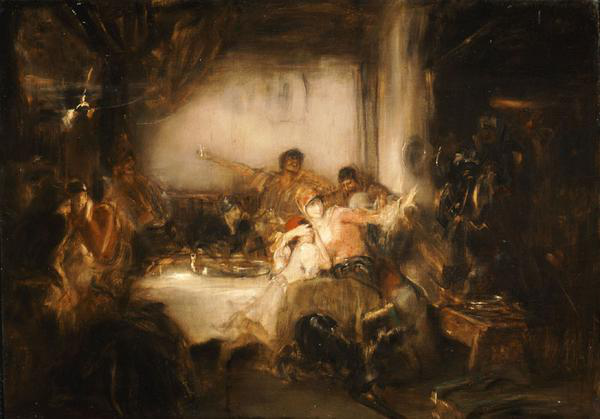

SOMETHING ELSE:	a grand party is currently under way and will last through the weekend
FEAR:	The people look like they're battling evil forces in the dark
CONTENTMENT:	the women in the  center stand out because of their position and their  lighter toned skin
AWE:	The lighting in this picture is wonderful.  is seems like you are looking through a porthole in time
FEAR:	The dark room and people look like something bad is about to happen.
AWE:	There is mystery in what the shadow figures are that the children are being shielded from
FEAR:	The darkish gloomy chaos portrays fear and terror. The franticness in the painting and crashing and darkness is a nice touch.
FEAR:	The darkess around the picrure makes it look like death is coming to get the people.
AMUSEMENT:	There is a group of gluttonous, drunken people having a good time at the dinner table.
FEAR:	sudden ambush from the darkness gives a dangerous mood
FEAR:	This scene looks scary because the woman is covering the eyes of the child in

In [8]:
show_random_captions(df, wikiart_img_dir)

Impressionism joaquã­n-sorolla_portrait-of-antonio-elegido-1893


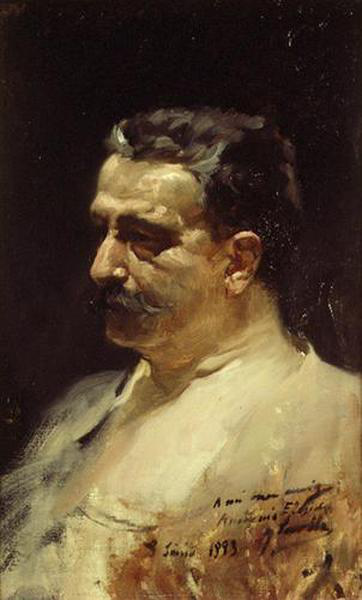

SADNESS:	The man looks tired since his face is so wrinkled
SOMETHING ELSE:	Ego and entitlement stand out in this image.
AMUSEMENT:	This man looks like a body double for Stalin!
AMUSEMENT:	This man looks like when he stands up that he is really overweight
DISGUST:	The horrible look on his face is making this painting more disgusting.


In [9]:
# Show captions for a random portait.
sb = df_with_genre[df_with_genre.genre == 'portrait']
show_random_captions(sb, wikiart_img_dir)

[<Figure size 864x288 with 1 Axes>, <Figure size 576x288 with 1 Axes>]

<Figure size 432x288 with 0 Axes>

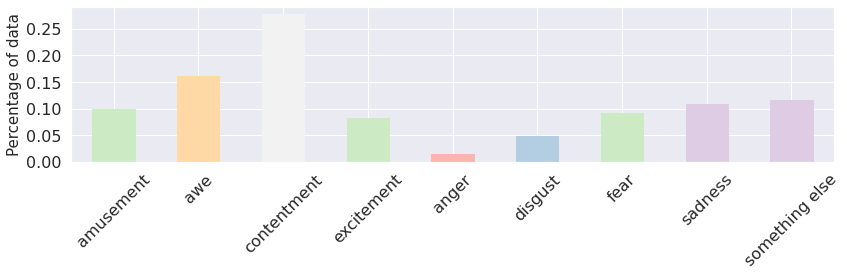

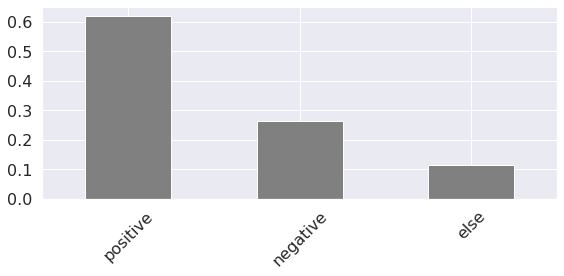

In [9]:
##
## make a histogram of the emotions
##
df_to_emotion_histogram(df)

In [10]:
df.groupby('pne')['emotion'].count() / len(df)

pne
0    0.620284
1    0.263236
2    0.116481
Name: emotion, dtype: float64

In [11]:
## Quick analysis on emotions and subjectivity.  (this can take up to a minute!)
has_pos_feels = grouped_artwork.apply(lambda group: 0 in group.pne.unique())
has_neg_feels = grouped_artwork.apply(lambda group: 1 in group.pne.unique())
has_else_feels = grouped_artwork.apply(lambda group: 2 in group.pne.unique())

c1 = (has_pos_feels & has_neg_feels)
c2 = (has_pos_feels & has_else_feels)
c3 = (has_neg_feels & has_else_feels)

stat1 = (c1).mean().round(2)
stat2 = (c1|c2|c3).mean().round(2)

print('Percent of artworks annotated with emotions that are POS _and_ NEG', stat1)
print('Percent of artworks annotated with emotions that are ELSE&NEG or ELSE&POS or NEG&POS', stat2)

Percent of artworks annotated with emotions that are POS _and_ NEG 0.61
Percent of artworks annotated with emotions that are ELSE&NEG or ELSE&POS or NEG&POS 0.79


In [12]:
#
# Majority-dominance in emotions (this can take up to a minute!)
#

# Find artworks where one emotion was indicated by
# at least half the annotators of that artwork.
emo_domi = grouped_artwork.apply(has_emotion_max_dominance)
emo_domi.mean(), emo_domi.sum()

(0.45649810698354387, 36534)

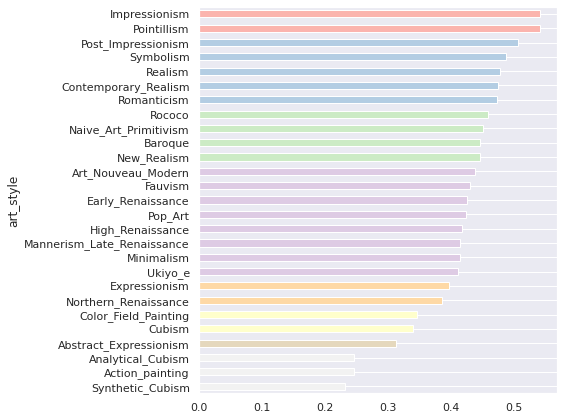

In [13]:
# Plot majority-dominance of emotions per art-style.
s = emo_domi.groupby('art_style').mean().sort_values()
norm = plt.Normalize(s.min(), s.max())
colors = plt.cm.Pastel1_r(norm(s.values))
fig = plt.figure(figsize=(8, 6))
ax = s.plot.barh(color=colors, )
ax.xaxis.grid() # horizontal lines
plt.tight_layout()
if save_figs:
    fig.savefig('emotional_majority_aggreement_per_art_style.jpg')

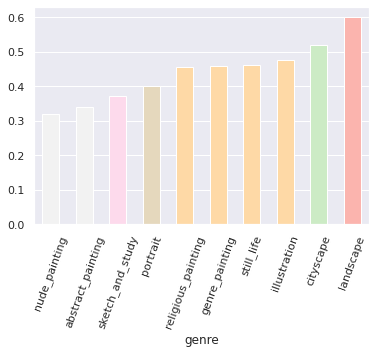

In [14]:
##
## Plot majority-dominance in emotions, per genre.
## 
# (recall - not all artworks have "genre" labels. working here with those that do.)

emo_domi.name = 'majority-aggreement'
temp = pd.merge(emo_domi, genre_info, on=['art_style', 'painting'])
s = temp.groupby('genre').mean().sort_values('majority-aggreement')
s = s['majority-aggreement']
norm = plt.Normalize(s.min(), s.max())
colors = plt.cm.Pastel1_r(norm(s.values))
fig = plt.figure()
ax = s.plot.bar(color=colors, grid=True, rot=70)
ax.xaxis.grid() # horizontal lines

if save_figs:
    fig.savefig('emotional_majority_aggreement_per_genre.jpg')

In [15]:
print('Majority-Dominance per genre (fractions).')
print(s)

Majority-Dominance per genre (fractions).
genre
nude_painting         0.320275
abstract_painting     0.339271
sketch_and_study      0.370615
portrait              0.400872
religious_painting    0.455667
genre_painting        0.459510
still_life            0.463092
illustration          0.474801
cityscape             0.518519
landscape             0.600874
Name: majority-aggreement, dtype: float64


In [16]:
# also now note the emotion that is the dominant (so we can count it per 1 of 9 "emotion" choices)
foo = partial(has_emotion_max_dominance, return_max=True)
emo_domi = grouped_artwork.apply(foo)
has_emo_domi = pd.Series([x[1] for x in emo_domi.values if x[0] == True]) # keeps only paintings where emo-dominance exists

# print the percentages (unormalized and normalized per emotion)
raw_emo_cnt = df.emotion.value_counts().to_dict()
emo_domi_cnt = has_emo_domi.value_counts().to_dict()
for emo in ARTEMIS_EMOTIONS:
    print("{:15}{:8}{:15.4f}".format(emo, emo_domi_cnt[emo], emo_domi_cnt[emo] / raw_emo_cnt[emo]))

amusement          2861         0.0631
awe                5292         0.0726
contentment       17050         0.1352
excitement         1325         0.0352
anger                50         0.0075
disgust             636         0.0284
fear               3329         0.0801
sadness            3845         0.0784
something else     2146         0.0405


In [17]:
is_met = df.utterance_spelled.apply(lambda x: sum([i in x for i in metaphorical_substrings]) >= 1)
print('Percent of annotations making a simile (approximate)', is_met.mean())

print('\nSamples:')
ds = df[is_met].sample(5)
for u in ds.utterance:
    print(u)

Percent of annotations making a simile (approximate) 0.2090770733080557

Samples:
The curves on the naked women are irresistable, even as the weather looks like it's about to destroy something
This looks like the people of this city are enjoying a great parade.
Jesus wearing a crown of thorns always makes me sad. Reminds me of His death.
It looks like a giant tidal wave is about to demolish something.
The water is the most lovely shade of blue, and it reminds me of the summer


Token Length per genre/art_style

genre
abstract_painting     15.338144
still_life            15.486418
sketch_and_study      15.584676
landscape             15.657401
nude_painting         15.662590
portrait              15.850017
cityscape             15.962521
religious_painting    16.249924
illustration          16.377809
genre_painting        16.460087
Name: tokens_len, dtype: float64
art_style
Pointillism                   13.734843
Analytical_Cubism             13.856911
Synthetic_Cubism              14.105140
Action_painting               14.219880
Fauvism                       14.466237
Contemporary_Realism          14.673891
Minimalism                    15.006980
Color_Field_Painting          15.066897
Ukiyo_e                       15.081784
New_Realism                   15.208874
Mannerism_Late_Renaissance    15.452249
Early_Renaissance             15.459722
High_Renaissance              15.538284
Pop_Art                       15.658450
Abstract_Expressionism        15.6718

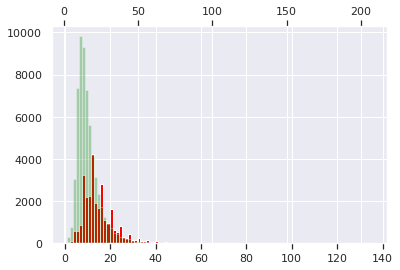

In [18]:
pedantic = True

if pedantic:
    print('Token Length per genre/art_style\n')
    print(df_with_genre.groupby('genre')['tokens_len'].mean().sort_values())
    print(df.groupby('art_style')['tokens_len'].mean().sort_values())
    
    fig, ax = plt.subplots()
    ax2 = ax.twiny()
    df_with_genre[df_with_genre['genre'] == 'abstract_painting']['tokens_len'].hist(bins=100, ax=ax, color='red')
    df_with_genre[df_with_genre['genre'] == 'genre_painting']['tokens_len'].hist(bins=100, ax=ax2, color='green', alpha=0.3)

Number of tokens per utterance (punctuations removed), for utterances with at most 50 tokens (99.34% of all utterances).


Text(0, 0.5, 'Number of utterances')

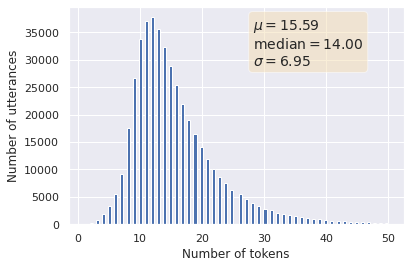

In [19]:
tokens_len = df.tokens_len[df.tokens_len <= 50]
print("Number of tokens per utterance (punctuations removed), for utterances with at most 50 tokens ({:.2f}% of all utterances).".format((df.tokens_len <= 50).mean() * 100))

mu = tokens_len.mean()
median = tokens_len.median()
sigma = tokens_len.std()
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))

ax = tokens_len.hist(bins=100)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.55, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.xlabel('Number of tokens', fontsize=12)
plt.ylabel('Number of utterances', fontsize=12)

In [20]:
def rough_fine_grained_emotion_analysis_of_something_else(tokens):
    found_counter = 0
    fine_grained_emotion_category = None
    for t in tokens:        
        for f in LARGER_EMOTION_VOCAB:
            if t in f:
                found_counter += 1
                fine_grained_emotion_category = f[0]
    
    if found_counter == 1: # found_exactly_one
        return fine_grained_emotion_category
    else:
        return 'unclassified'

n_se = (df.emotion == 'something else').sum()
print('annotations with something-else choice:', n_se)

annotations with something-else choice: 52962


In [21]:
se = df[df.emotion == 'something else']
fg_se_emo = se['tokens'].apply(rough_fine_grained_emotion_analysis_of_something_else)
print('These emotion-words or synnonyms are found exactly once in these many SE annotations:')
fg_se_emo.value_counts()

These emotion-words or synnonyms are found exactly once in these many SE annotations:


unclassified      36836
confused           5333
bored              3904
curious            3889
happy               690
uncomfortable       371
anxiety             310
nostalgia           309
hope                295
neutral             285
creepy              277
depressing          136
overwhelmed          76
bothered             56
anticipation         49
shock                36
disappointment       31
shame                17
shy                  15
surprised            12
alerted              11
rage                  6
grief                 4
empowerment           4
thrilled              4
exhilarating          3
insult                3
Name: tokens, dtype: int64

In [24]:
def pne(group):
    "return number of positive:0, negative:1, and som-else:2 in a group"
    p = sum(group == 0)
    n = sum(group == 1)
    e = sum(group == 2)    
    return p, n, e

def pne_distribution_plot(pne_of_stim, grouping_col):
    new_stats = []
    for n, g in pne_of_stim.groupby(grouping_col):
        tc = sum([np.array(x) for x in g.values])
        tc = [i /sum(tc) for i in tc]
        new_stats.append([n, tc])

    ns = pd.DataFrame.from_dict(dict(new_stats)).T
    ns = ns.rename(columns={0:'pos', 1:'neg', 2:'else'})
    ns = ns.sort_values(by='pos')

    title = 'Positive vs Negative vs. Else \n Emotion Distribution'

    kw = {'figsize': (6, 6), 
          'fontsize': 12,
          'grid': True,
          'title': title}

    
    ns['pos'].plot(kind='barh', color='#2f9c3b', **kw)
    ns['neg'].plot(kind='barh', left=ns['pos'], color='#FE2020')
    ns['else'].plot(kind='barh', left=ns['pos']+ns['neg'], color='#6b8abd')
    
    if save_figs:
        plt.savefig('pos_neg_else_distribution_per_{}.jpg'.format(grouping_col))
    
    return plt.tight_layout()

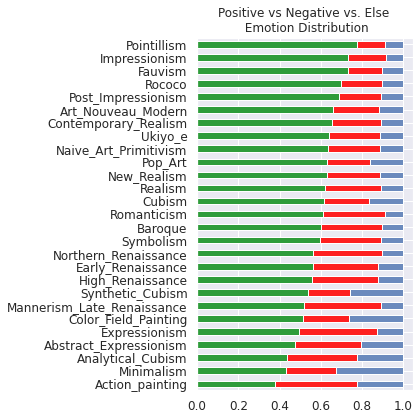

In [26]:
## Plot pos-vs-neg-vs-else as mass per art_style
grouping_col = 'art_style'
stimuli = df.groupby([grouping_col])
pne_of_stim = stimuli.pne.apply(pne)
pne_distribution_plot(pne_of_stim, grouping_col)

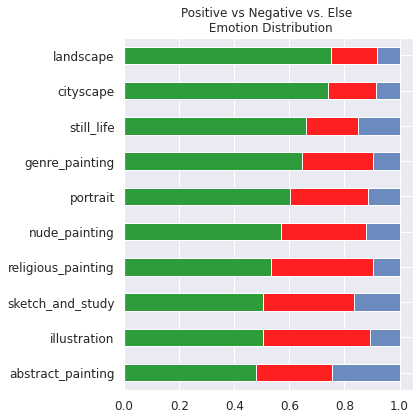

In [28]:
## Plot pos-vs-neg-vs-else as mass per genre
grouping_col = 'genre'
stimuli = df_with_genre.groupby([grouping_col])
pne_of_stim = stimuli.pne.apply(pne)
pne_distribution_plot(pne_of_stim, grouping_col)

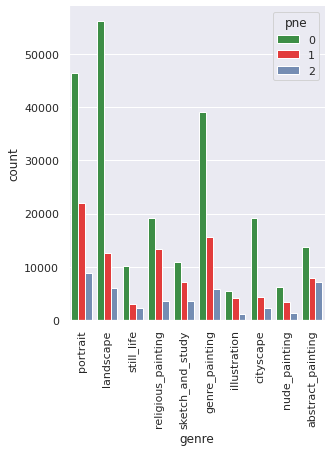

In [31]:
#
# plot pos-neg-else histogram per genre. 
# Note. Abstract paintings get most "2" (somethin-else) per proportion of their size.
#       Landscapes the most positive emotions "0".

c = sns.catplot(x="genre", 
                hue="pne", 
                data=df_with_genre, 
                kind="count",                 
                palette={1: "#FE2020", 
                         0: "#2f9c3b", 
                         2: "#6b8abd"},                                
                legend_out=False)

c.set_xticklabels(rotation=90)

In [33]:
## see the normalized statistics of the above plot.
x, y = 'genre', 'pne'
df1 = df_with_genre.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1

genre               pne
abstract_painting   0      47.776194
                    1      27.638488
                    2      24.585318
cityscape           0      74.203958
                    1      17.110532
                    2       8.685510
genre_painting      0      64.751085
                    1      25.674870
                    2       9.574045
illustration        0      50.324401
                    1      38.975082
                    2      10.700517
landscape           0      74.976635
                    1      16.898983
                    2       8.124382
nude_painting       0      56.832812
                    1      30.991356
                    2      12.175832
portrait            0      60.047404
                    1      28.534238
                    2      11.418358
religious_painting  0      53.482359
                    1      36.819863
                    2       9.697779
sketch_and_study    0      50.446634
                    1      33.193664
              

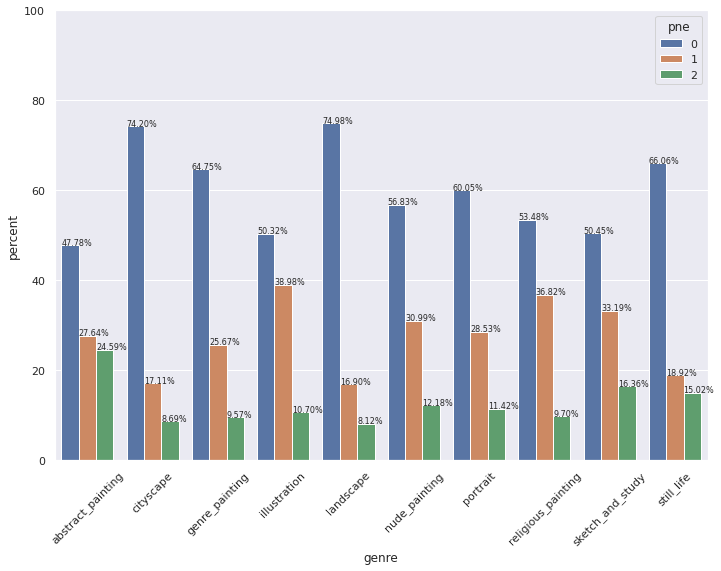

In [54]:
## plot them.
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27) # the size of A4 paper
# df1 = df1.rename('percent').reset_index()
g = sns.barplot(x=x, y='percent', hue=y, data=df1, ax=ax)
for item in g.get_xticklabels():
    item.set_rotation(45)
    
ax.set_ylim(0,100)
for p in ax.patches:    
    txt = '{:.2f}%'.format(p.get_height())
    txt_x = p.get_x() 
    txt_y = p.get_height() + 0.02
    ax.text(txt_x, txt_y, txt, fontsize=8)

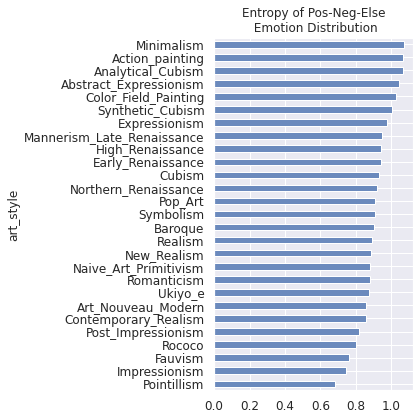

In [30]:
#
# plot the entropy of the pos-neg-else (ternary) distribution per art_style
#
grouping_col = 'art_style'
stimuli = df.groupby([grouping_col])
pne_of_stim = stimuli.pne.apply(pne)


pne_of_stim.apply(entropy).groupby(grouping_col).mean().sort_values().plot(kind='barh', 
                                                                          figsize=(6, 6), 
                                                                          fontsize=12,
                                                                          grid=True,
                                                                          title='Entropy of Pos-Neg-Else\n Emotion Distribution',
                                                                          color='#6b8abd')
plt.tight_layout()
if save_figs:
    plt.savefig('pos_neg_else_distribution_entropy_per_art_style.jpg')